**IMPORTING NECESSARY LIBRARIES**

In [238]:
!pip install scikeras
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**LOADING THE DATASET**

In [240]:
images_folder = ('/content/drive/My Drive/Colab Notebooks/Final Project/UTKFace')


In [241]:
# using image_paths to store image names and age_labels to store ages
image_paths = []
age_labels = []

In [242]:

from tqdm import tqdm

# looking through all the image files in the loaded folder and appending to the vaiours list
for filename in tqdm(sorted(os.listdir(images_folder))):
    image_path = os.path.join(images_folder, filename)
    temp = filename.split('_')
    age  = int(temp[0])

    image_paths.append(image_path)
    age_labels.append(age)

# Creating a dataframe for the data
df = pd.DataFrame()
df['image'], df['label'] = image_paths, age_labels
df




100%|██████████| 23738/23738 [00:00<00:00, 516439.59it/s]


,image,label
0,/content/drive/My Drive/Colab Notebooks/Final ...,100
1,/content/drive/My Drive/Colab Notebooks/Final ...,100
2,/content/drive/My Drive/Colab Notebooks/Final ...,100
3,/content/drive/My Drive/Colab Notebooks/Final ...,100
4,/content/drive/My Drive/Colab Notebooks/Final ...,100
...,...,...
23733,/content/drive/My Drive/Colab Notebooks/Final ...,9
23734,/content/drive/My Drive/Colab Notebooks/Final ...,9
23735,/content/drive/My Drive/Colab Notebooks/Final ...,9
23736,/content/drive/My Drive/Colab Notebooks/Final ...,9


In [243]:
# Define the age group boundaries
age_groups = [(1, 2), (3, 6), (7, 12), (13, 17), (18, 25), (26, 32), (33, 39),
              (40, 46), (47, 52), (53, 59), (60, 66), (67, 74), (75, 82), (83,150)]

# Function to map age to age group
def map_age_to_group(age):
    for group in age_groups:
        if group[0] <= int(age) <= group[1]:
            return f"{group[0]}-{group[1]}"
    return "Unknown"

# Apply the function to create a new 'age_group' column in your DataFrame
df['age'] = df['label'].apply(map_age_to_group)

# Display the first few rows of the DataFrame with the new 'age_group' columnd
df

,image,label,age
0,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150
1,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150
2,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150
3,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150
4,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150
...,...,...,...
23733,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12
23734,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12
23735,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12
23736,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12


**EXPLORATORY DATA ANALYSIS**

AxesImage(size=(200, 200))


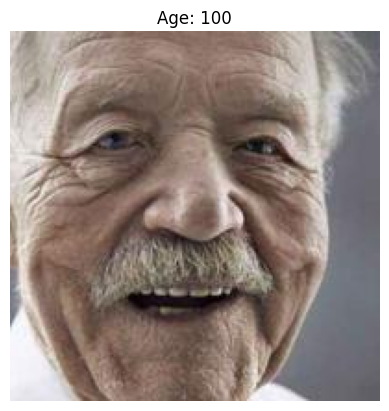

In [244]:
# Displaying first image of the dataset
each_image = Image.open(df['image'][0])
plt.title(f"Age: {int(df['label'][0])}")
plt.axis('off')
print(plt.imshow(each_image))

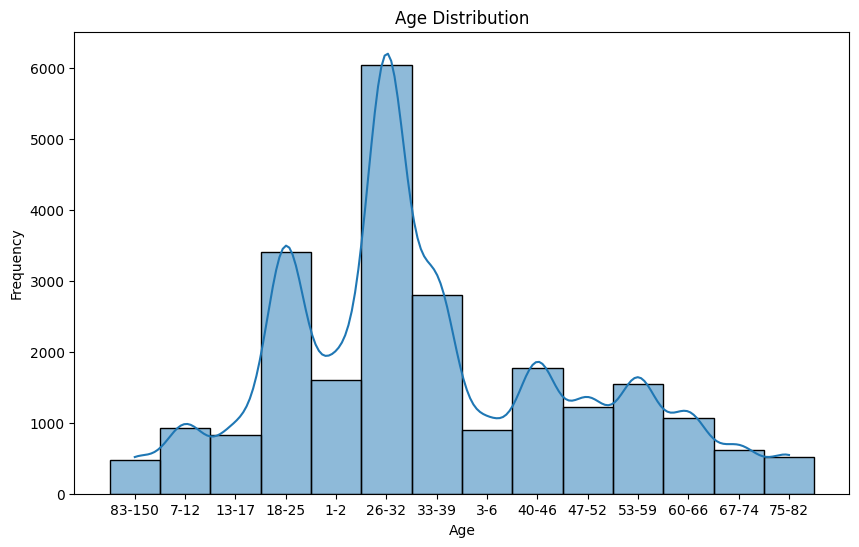

In [245]:
# Histogram of age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

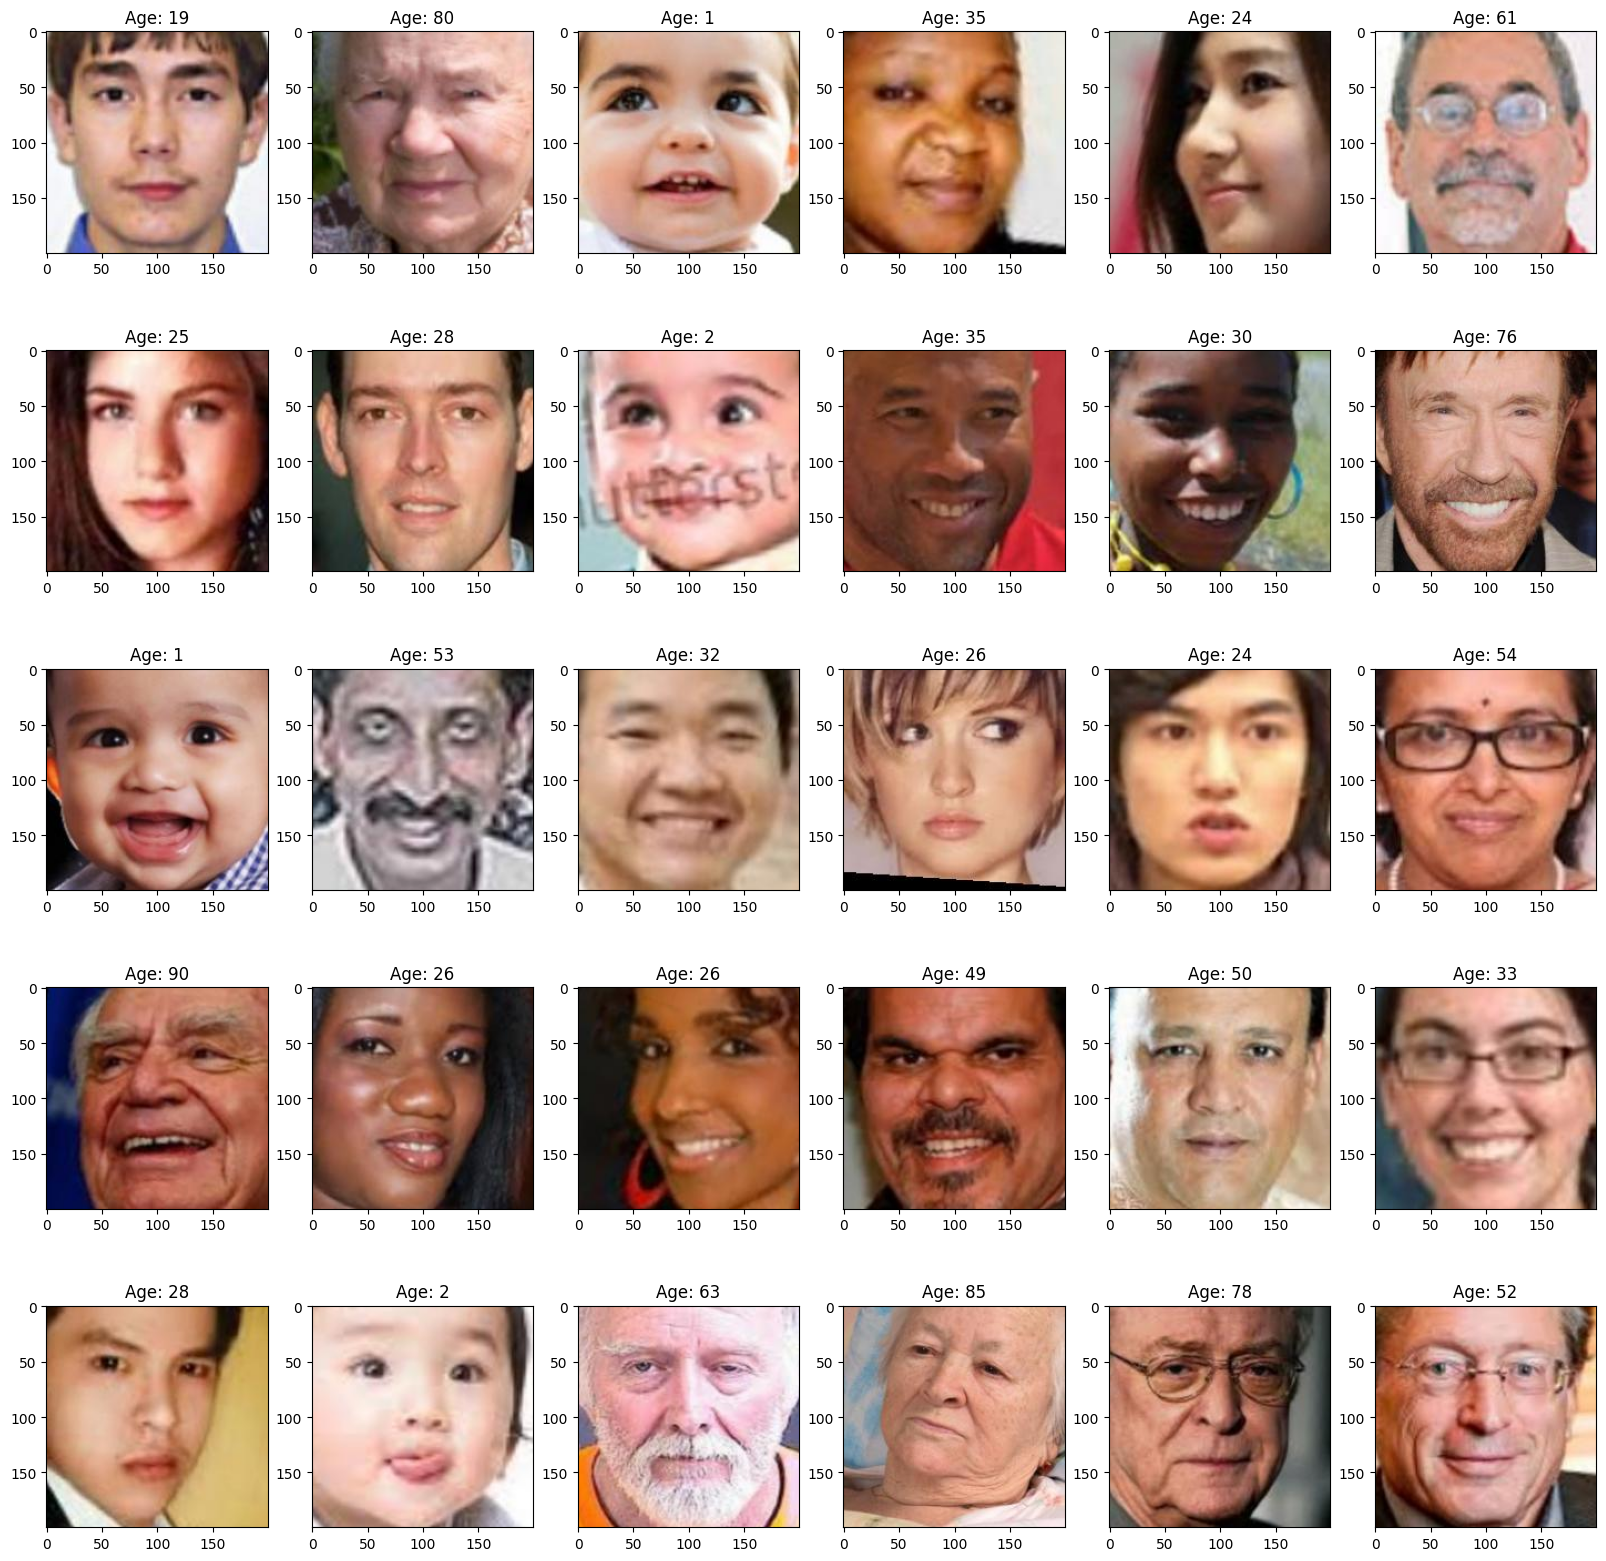

In [246]:
# Randomly displaying 30 images in the dataset
plt.figure(figsize = (20,20))
files = df.sample(frac=1, random_state=42).reset_index(drop=True)


for index, row in enumerate(files.head(30).itertuples()):
  image = row[1]
  age = row[2]
  plt.subplot(5,6, index+1)
  each_image = load_img(image)
  img = np.array(each_image)

  plt.imshow(each_image)
  plt.title(f"Age: {int(age)}")


**DATA PREPROCESSING**

In [247]:
le = LabelEncoder()
df['age'] = le.fit_transform(df['age'])

# One-hot encoding for age groups
df['age_group_encoded'] = pd.Categorical(df['age']).codes


# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
df

,image,label,age,age_group_encoded
0,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150,13
1,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150,13
2,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150,13
3,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150,13
4,/content/drive/My Drive/Colab Notebooks/Final ...,100,83-150,13
...,...,...,...,...
23733,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12,11
23734,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12,11
23735,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12,11
23736,/content/drive/My Drive/Colab Notebooks/Final ...,9,7-12,11


**FEATURE EXTRACTION**

In [248]:
1-2, 3-6, 7-12, 13- 17, 18-25, 26-32, 33-39, 40-46, 47 -52, 53 - 59, 60 - 66, 67 - 74, 75-82, 83 - 100

(-1, -3, -5, -4, -7, -6, -6, -6, -5, -6, -6, -7, -7, -17)

In [249]:
# Feature Extraction
def extract_features(images):
    features = []
    for image in images:
        each_image = load_img(image, color_mode = "grayscale")
        each_image = each_image.resize((150, 150), Image.LANCZOS)
        each_image = np.array(each_image)
        features.append(each_image)

    features = np.array(features)
    features = features.reshape(len(features), 150, 150, 1)
    return features

In [ ]:
# Extract features for training, validation, and test sets
X_train = extract_features(train_df['image'])
X_val = extract_features(val_df['image'])
X_test = extract_features(test_df['image'])

y_train = train_df['age_group_encoded']
y_val = val_df['age_group_encoded']
y_test = test_df['age_group_encoded']

y_test_label = test_df['age']

In [ ]:
import utils
from keras.utils import to_categorical

# Convert age group labels to one-hot encoded vectors
y_train_encoded = to_categorical(y_train, num_classes=len(df['age_group_encoded'].unique()))
y_val_encoded = to_categorical(y_val, num_classes=len(df['age_group_encoded'].unique()))
y_test_encoded = to_categorical(y_test, num_classes=len(df['age_group_encoded'].unique()))

In [252]:
# Normalizing the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

**MODEL CREATION**

In [253]:
input_shape = (150, 150, 1)
num_classes = 14


In [254]:
# Function to create the model using functional API
def create_model(optimizer='adam', dropout_rate=0.001):
    input_shape = (150, 150, 1)

    # Input layer
    input_layer = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Flatten layer
    flatten = Flatten()(pool4)

    # Fully connected layers
    dense1 = Dense(256, activation='relu')(flatten)
    dropout1 = Dropout(dropout_rate)(dense1)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax', name='age_out')(dropout1)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [255]:
# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=128, dropout_rate=0.04, verbose=0)

**TRAINING AND OPTIMIZATION**

In [256]:
# Define hyperparameters to search
param_grid = {
    'optimizer': ['adam'],
    'dropout_rate': [0.04, 0.05, 0.07]
}

In [257]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train_encoded)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

In [258]:
best_params = grid_result.best_params_
print("Best Parameters: ", grid_result.best_params_)

Best Parameters:  {'dropout_rate': 0.05, 'optimizer': 'adam'}


In [259]:
best_model = create_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])
best_model.summary()

Model: "model_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_133 (InputLayer)      [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_528 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_528 (MaxPool  (None, 74, 74, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_529 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_529 (MaxPool  (None, 36, 36, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_530 (Conv2D)         (None, 34, 34, 128)       73

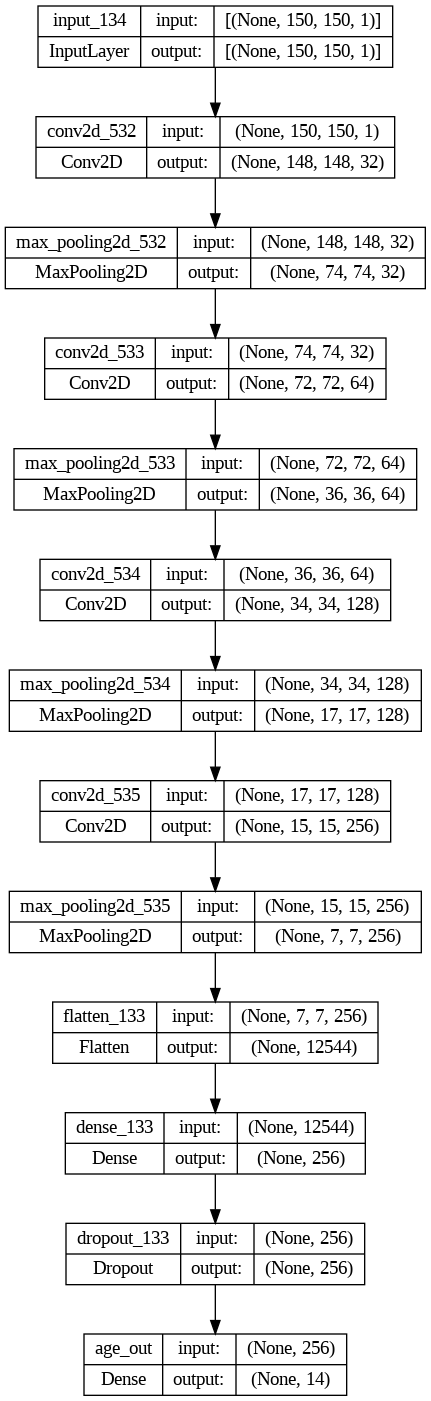

In [260]:
# Plotting the model's processing layers
from keras.utils import plot_model
best_model = create_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/50
475/475 [==============================] - 14s 26ms/step - loss: 2.0621 - accuracy: 0.2997 - val_loss: 1.7469 - val_accuracy: 0.3636
Epoch 2/50
475/475 [==============================] - 11s 24ms/step - loss: 1.7101 - accuracy: 0.3619 - val_loss: 1.5884 - val_accuracy: 0.3965
Epoch 3/50
475/475 [==============================] - 12s 24ms/step - loss: 1.5686 - accuracy: 0.3978 - val_loss: 1.5209 - val_accuracy: 0.4057
Epoch 4/50
475/475 [==============================] - 11s 24ms/step - loss: 1.4613 - accuracy: 0.4296 - val_loss: 1.4699 - val_accuracy: 0.4215
Epoch 5/50
475/475 [==============================] - 11s 24ms/step - loss: 1.3726 - accuracy: 0.4587 - val_loss: 1.4443 - val_accuracy: 0.4326
Epoch 6/50
475/475 [==============================] - 11s 24ms/step - loss: 1.2906 - accuracy: 0.4834 - val_loss: 1.4797 - val_accuracy: 0.4231
Epoch 7/50
475/475 [==============================] - 11s 24ms/step - loss: 1.2033 - accuracy: 0.5221 - val_loss: 1.4992 - val_accuracy:

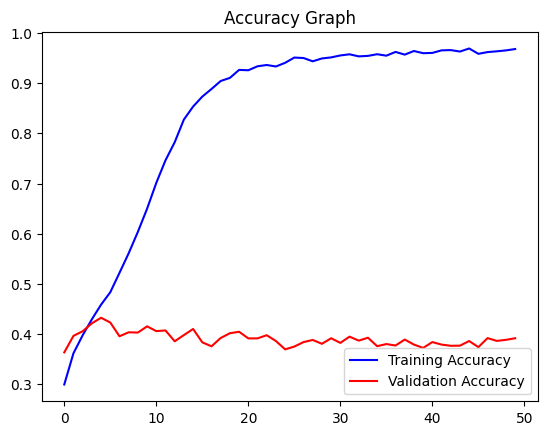

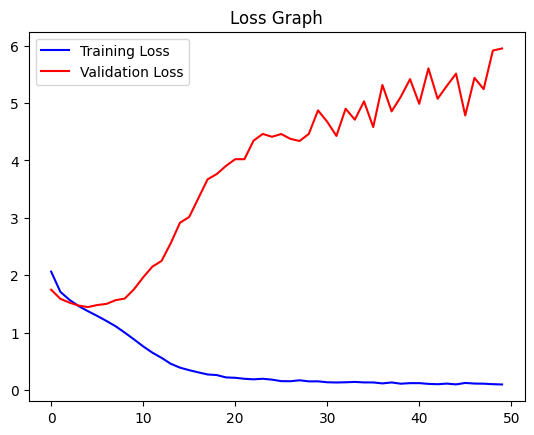

In [261]:
# plot results for
history = best_model.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_val, y_val_encoded))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Ploting the models performance
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

**TESTING AND EVALUATION**

In [262]:
# Evaluating the best model on the test set
# Evaluating the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_train, y_train_encoded)
print(f'Train Loss: {test_loss:.4f}, Train Accuracy: {test_accuracy:.4f}')


test_loss, test_accuracy = best_model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Evaluating the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_val, y_val_encoded)
print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}')

475/475 [==============================] - 4s 8ms/step - loss: 0.0545 - accuracy: 0.9814
Train Loss: 0.0545, Train Accuracy: 0.9814
149/149 [==============================] - 1s 8ms/step - loss: 5.9632 - accuracy: 0.3987
Test Loss: 5.9632, Test Accuracy: 0.3987
119/119 [==============================] - 1s 8ms/step - loss: 5.9492 - accuracy: 0.3918
Val Loss: 5.9492, Val Accuracy: 0.3918


In [263]:
# Predictions on the test set
predictions = best_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

149/149 [==============================] - 1s 6ms/step


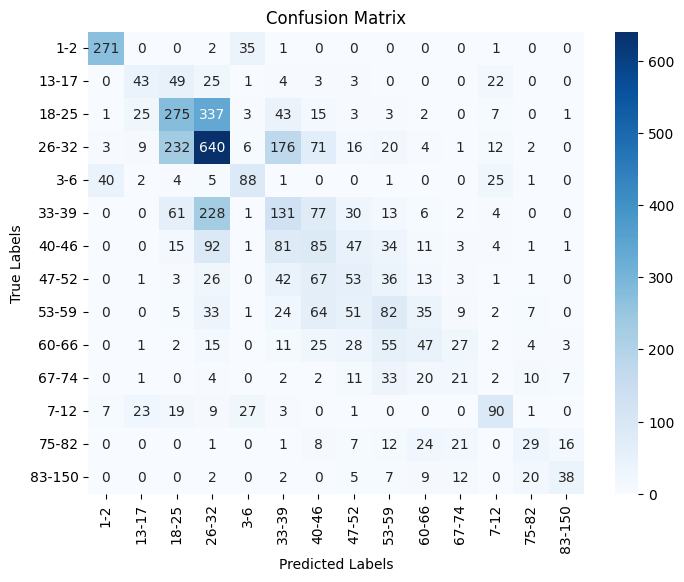

In [273]:
# Display confusion matrix
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test = le.fit_transform(y_test_label.astype(str))
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [274]:
# Classification Report
class_report = classification_report(y_test, predicted_labels, target_names=[str(label) for label in le.classes_])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         1-2       0.84      0.87      0.86       310
       13-17       0.41      0.29      0.34       150
       18-25       0.41      0.38      0.40       715
       26-32       0.45      0.54      0.49      1192
         3-6       0.54      0.53      0.53       167
       33-39       0.25      0.24      0.24       553
       40-46       0.20      0.23      0.21       375
       47-52       0.21      0.22      0.21       246
       53-59       0.28      0.26      0.27       313
       60-66       0.27      0.21      0.24       220
       67-74       0.21      0.19      0.20       113
        7-12       0.52      0.50      0.51       180
       75-82       0.38      0.24      0.30       119
      83-150       0.58      0.40      0.47        95

    accuracy                           0.40      4748
   macro avg       0.40      0.36      0.38      4748
weighted avg       0.40      0.40      0.39      4748



SAVING THE MODEL FOR DEPLOYMENT

In [278]:
best_model.save('/content/drive/My Drive/Colab Notebooks/Final Project/best_model_1.h5')